# MLP autoencoders

An autoencoder is a network that consists of two main parts:
- an *encoder*, which projects the data into a latent space to transform it into a compact representation.
- a *decoder*, which reconstructs the input data from the latent representation.

In mathematical terms, a data point $\mathbf{x} \in \mathbb{R}^N$ is transformed into a latent representation $\mathbf{z} \in \mathbb{R}^L$, where $L \ll N$. Then, the latent representation is passed to the decoder, which produces an approximation $\hat{\mathbf{x}} \in \mathbb{R}^N$ of the input data, i.e., such that $\hat{\mathbf{x}} \approx \mathbf{x}$.

Autoencoders are very useful in many applications. For instance, in image processing, they are used for image denoising, compression, and generative models (image synthesis and transformation). They can also be used for transfer learning: first an autoencoder is trained to learn a latent representation of the data, and then this representation can be used for other classification/regression tasks.

<center><a href="https://emkademy.medium.com/1-first-step-to-generative-deep-learning-with-autoencoders-22bd41e56d18">
    <img src="https://miro.medium.com/max/772/1*ztZn098tDQsnD5J6v1eNuQ.png" width="600"></a></center>


In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [3]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

## Dataset

In [4]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Load the MNIST dataset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(train_data, torch.arange(50))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [6]:
# Get a batch of images from the train dataloader (no need for the labels here)
image_batch_example = next(iter(train_dataloader))[0]

## The encoder

First, let us write the encoder. We consider a 3-layer encoder, where each layer consists of a Linear part and a ReLU activation function. The first layer goes from size `input_size` to 128, the second layer from 128 to 64, and the third layer from 64 to 32.

In [9]:
# TO DO: write the encoder class ('__init__' and 'forward' methods)
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),  # layer 1
            nn.ReLU(),
            nn.Linear(128, 64),          # layer 2
            nn.ReLU(),
            nn.Linear(64, 32)            # layer 3 (latent space)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        return x

In [10]:
# TO DO:
# - instanciate an encoder (get the proper input size)
# - vectorize image_batch_example into image_batch_example_vec
# - apply the encoder to image_batch_example_vec to produce the latent representation 'z'
# - print the size of z, and the size of the image_batch_example_vec

input_size = 28 * 28
# instantiate the encoder
encoder = Encoder(input_size)

# initialize the params
encoder.apply(init_params)

# vectorization
image_batch_example_vec = image_batch_example.view(image_batch_example.size(0), -1)

# apply the encoder
z = encoder(image_batch_example_vec)

print(f'Size of image_batch_example_vec: {image_batch_example_vec.size()}')
print(f'Size of latent representation z: {z.size()}')

Size of image_batch_example_vec: torch.Size([8, 784])
Size of latent representation z: torch.Size([8, 32])


You can see that the latent representation has a significantly smaller dimension than the original data (vectorized image).


## The decoder

The decoder as a similar structure than the encoder (3 {Linear + activation} layers) but the sizes are flipped: the first layer goes from 32 to 64, the second layer goes from 64 to 128, and the last layer goest from 128 back to the input size. The first and second layers use a ReLU activation, but the last layer uses a Sigmoid: this forces the output to be in the range $[0,1]$, which corresponds to the normalized images.

In [11]:
# TO DO: write the decoder class ('__init__' and 'forward' methods)
class Decoder(nn.Module):
    def __init__(self, output_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),     # layer 1
            nn.ReLU(),
            nn.Linear(64, 128),    # layer 2
            nn.ReLU(),
            nn.Linear(128, output_size),  # layer 3
            nn.Sigmoid()           # scale output b/w 0 and 1
        )
        
    def forward(self, x):
        x = self.decoder(x)
        return x

In [13]:
# TO DO:
# - instanciate a decoder
# - apply it to the latent representation z computed before
# - print the size of the output 'y' of the decoder : it should be the same as the input data 'image_batch_example_vec'

decoder = Decoder(input_size)

# init params
decoder.apply(init_params)

# apply the decoder
y = decoder(z)

print(f'Size of reconstructed output y: {y.size()}')
print(f'Size of original input image_batch_example_vec: {image_batch_example_vec.size()}')

Size of reconstructed output y: torch.Size([8, 784])
Size of original input image_batch_example_vec: torch.Size([8, 784])


## The autoencoder main module

Finally we can write the autoencoder module. It simply consists of an encoder and a decoder applied sequentially.

<span style="color:red">**Exercice 3**</span> Write the MLP autoencoder class. Instanciate an MLP autoencoder, initialize its parameters, and print the number of parameters.

In [15]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size)
        self.decoder = Decoder(input_size)
        
    def forward(self, x):
        # Flatten the input if it's an image
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        # Encode
        z = self.encoder(x)
        # Decode
        y = self.decoder(z)
        return y

In [16]:
# Instantiate the autoencoder
input_size = 28 * 28  # 784
autoencoder = Autoencoder(input_size)

# Initialize the autoencoder's parameters
torch.manual_seed(0)  # For reproducibility
autoencoder.apply(init_params)

# Print the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(autoencoder)
print(f'Total number of parameters in the autoencoder: {total_params}')

Total number of parameters in the autoencoder: 222384


## Training

Now we can write the training function (with validation !). It's very similar to the training function for the MLP classifier from the previous script, up to three main differences:
- Since we don't try to predict a label, we don't need to load them when iterating over the dataloader.
- The loss function is no longer Cross Entropy (which is for classification), but [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html?highlight=mse#torch.nn.MSELoss) (*cf.* lab 2).
- For validation, unlike for classification, we monitor the MSE loss (instead of the accuracy), thus it should be decreasing (instead of increasing).

Regarding the loss, remember that the autoencoder tries to compress the input data $\mathbf{x}$ (through the encoder) and then produce an approximation $\hat{\mathbf{x}}$ of this input data (through the decoder). This means that the input and output of the decoder should have the same dimension, and the loss is computed between these two quantities: $\mathcal{L}(\hat{\mathbf{x}}, \mathbf{x})$.

<span style="color:red">**Exercice 4**</span> Write the autoencoder training function with validation (you also need to write the evaluation function). Train the autoencoder (30 epochs, learning rate=0.001, and MSE loss function), and plot the training and validation losses over epochs.

In [17]:
def eval_autoencoder(model, dataloader, loss_fn):
    model.eval()  # evaluation mode
    total_loss = 0.0
    
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0]  # inputs
            inputs = inputs.view(inputs.size(0), -1)  # flatten the inputs
            
            # forward pass
            outputs = model(inputs)
            
            # loss function
            loss = loss_fn(outputs, inputs)
            total_loss += loss.item() * inputs.size(0)  # get total loss
    
    # Avg loss over the dataset
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [18]:
# training with validation
def train_autoencoder(model, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs):
    best_model = None
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()  # training mode
        running_loss = 0.0
        
        for data in train_dataloader:
            inputs = data[0]  # the inputs
            inputs = inputs.view(inputs.size(0), -1)  # flatten the inputs
            
            # forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, inputs)
            
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)  # get total loss
        
        # avg training loss over the epoch
        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)
        
        # evaluate on validation set
        val_loss = eval_autoencoder(model, valid_dataloader, loss_fn)
        val_losses.append(val_loss)
        
        # track the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    return best_model, train_losses, val_losses

Epoch [1/30], Training Loss: 0.8515, Validation Loss: 0.8075
Epoch [2/30], Training Loss: 0.7261, Validation Loss: 0.7439
Epoch [3/30], Training Loss: 0.6758, Validation Loss: 0.7020
Epoch [4/30], Training Loss: 0.6388, Validation Loss: 0.6779
Epoch [5/30], Training Loss: 0.6203, Validation Loss: 0.6676
Epoch [6/30], Training Loss: 0.6094, Validation Loss: 0.6630
Epoch [7/30], Training Loss: 0.6049, Validation Loss: 0.6592
Epoch [8/30], Training Loss: 0.5955, Validation Loss: 0.6501
Epoch [9/30], Training Loss: 0.5877, Validation Loss: 0.6453
Epoch [10/30], Training Loss: 0.5815, Validation Loss: 0.6419
Epoch [11/30], Training Loss: 0.5772, Validation Loss: 0.6393
Epoch [12/30], Training Loss: 0.5718, Validation Loss: 0.6380
Epoch [13/30], Training Loss: 0.5683, Validation Loss: 0.6341
Epoch [14/30], Training Loss: 0.5654, Validation Loss: 0.6337
Epoch [15/30], Training Loss: 0.5622, Validation Loss: 0.6302
Epoch [16/30], Training Loss: 0.5590, Validation Loss: 0.6306
Epoch [17/30], Tr

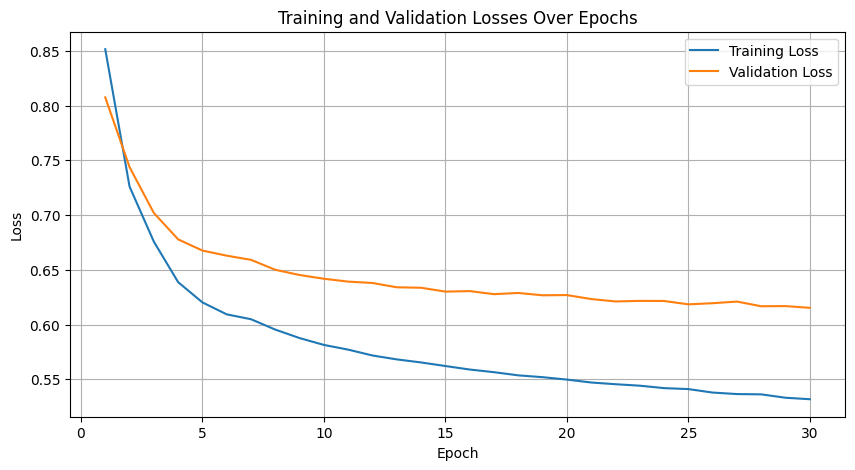

In [19]:
# train params
loss_fn = nn.MSELoss()
num_epochs = 30
learning_rate = 0.001

# instantiate the autoencoder
input_size = 28 * 28  # MNIST images are 28x28 pixels
autoencoder = Autoencoder(input_size)

# initialize params
torch.manual_seed(0)  
autoencoder.apply(init_params)

# Adam optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# train
best_model, train_losses, val_losses = train_autoencoder(
    autoencoder, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs
)

# plot the training and validation losses
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Visualization

Once the autoencoder is trained, we can use it to reconstruct an input image.

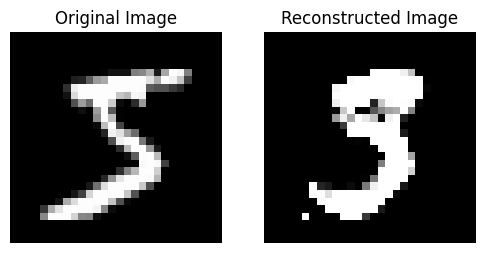

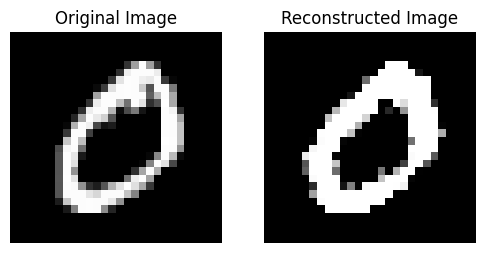

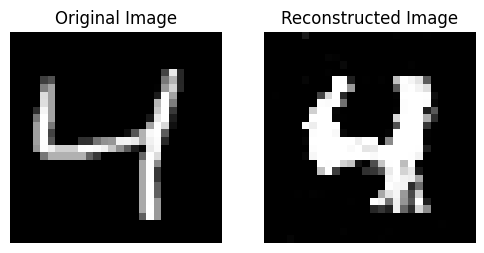

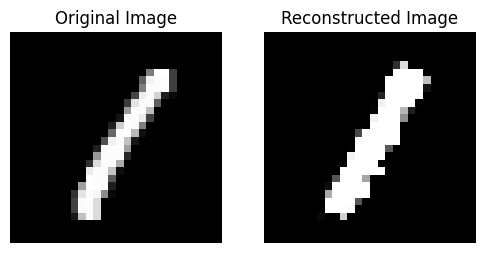

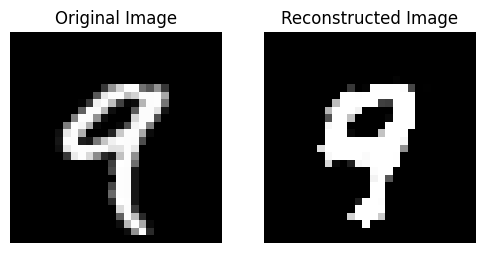

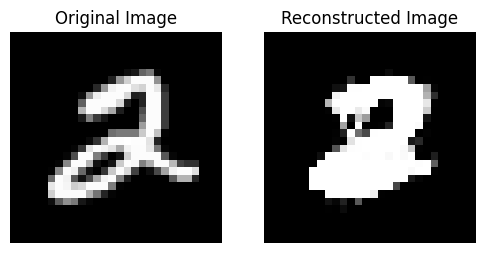

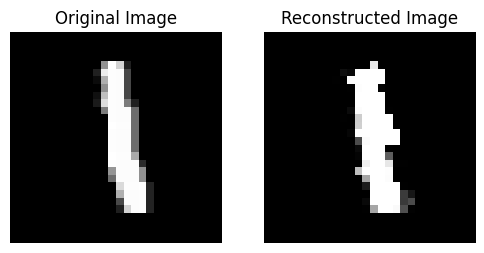

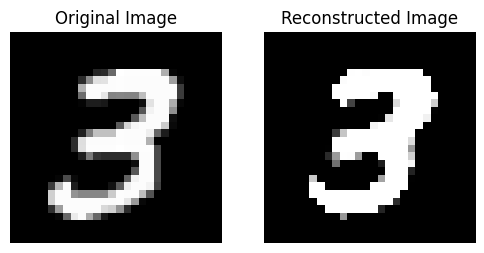

In [23]:
# Get a sample from the test dataloader
test_batch = next(iter(test_dataloader))[0]  # We only need the images
bsize = test_batch.shape[0]  # Batch size

# Flatten the images
test_batch_vec = test_batch.view(bsize, -1)

# Pass through the trained autoencoder
autoencoder.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_batch_vec_pred = best_model(test_batch_vec)

# Reshape the predictions back to image dimensions
test_batch_pred = test_batch_vec_pred.view(bsize, 1, 28, 28)

# Plot the original and reconstructed images
for ib in range(bsize):
    plt.figure(figsize=(6, 3))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(test_batch[ib, 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(test_batch_pred[ib, 0], cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.show()